# Lorenz Parameter Estimation Benchmarks
https://benchmarks.juliadiffeq.org/html/ParameterEstimation/LorenzParameterEstimation.html

## Estimate the parameters of the Lorenz system from the dataset
Note: If data is generated with a fixed time step method and then is tested against with the same time step, there is a biased introduced since it's no longer about hitting the true solution, rather it's just about retreiving the same values that the ODE was first generated by! Thus this version uses adaptive timestepping for all portions so that way tests are against the true solution.

In [2]:
using ParameterizedFunctions, OrdinaryDiffEq, DiffEqParamEstim
using BlackBoxOptim, NLopt, Plots
pyplot(fmt=:png)

Plots.PyPlotBackend()

In [3]:
Xiang2015Bounds = Tuple{Float64, Float64}[(9, 11), (20, 30), (2, 3)] # for local optimizations
xlow_bounds = [9.0,20.0,2.0]
xhigh_bounds = [11.0,30.0,3.0]
LooserBounds = Tuple{Float64, Float64}[(0, 22), (0, 60), (0, 6)] # for global optimization
GloIniPar = [0.0, 0.5, 0.1] # for global optimizations
LocIniPar = [9.0, 20.0, 2.0] # for local optimization

3-element Array{Float64,1}:
  9.0
 20.0
  2.0

In [4]:
g1 = @ode_def LorenzExample begin
  dx = σ*(y-x)
  dy = x*(ρ-z) - y
  dz = x*y - β*z
end σ ρ β
p = [10.0,28.0,2.66] # Parameters used to construct the dataset
r0 = [1.0; 0.0; 0.0]                #[-11.8,-5.1,37.5] PODES Initial values of the system in space # [0.1, 0.0, 0.0]
tspan = (0.0, 30.0)                 # PODES sample of 3000 observations over the (0,30) timespan
prob = ODEProblem(g1, r0, tspan,p)
tspan2 = (0.0, 3.0)                 # Xiang test sample of 300 observations with a timestep of 0.01
prob_short = ODEProblem(g1, r0, tspan2,p)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 3.0)
u0: [1.0, 0.0, 0.0]

In [5]:
dt = 30.0/3000
tf = 30.0
tinterval = 0:dt:tf
t  = collect(tinterval)

3001-element Array{Float64,1}:
  0.0 
  0.01
  0.02
  0.03
  0.04
  0.05
  0.06
  0.07
  0.08
  0.09
  0.1 
  0.11
  0.12
  ⋮   
 29.89
 29.9 
 29.91
 29.92
 29.93
 29.94
 29.95
 29.96
 29.97
 29.98
 29.99
 30.0 

In [6]:
h = 0.01
M = 300
tstart = 0.0
tstop = tstart + M * h
tinterval_short = 0:h:tstop
t_short = collect(tinterval_short)

301-element Array{Float64,1}:
 0.0 
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 0.1 
 0.11
 0.12
 ⋮   
 2.89
 2.9 
 2.91
 2.92
 2.93
 2.94
 2.95
 2.96
 2.97
 2.98
 2.99
 3.0 

In [8]:
# Generate Data
data_sol_short = solve(prob_short,Vern9(),saveat=t_short,
    reltol=1e-9,abstol=1e-9)
# This operation produces column major dataset obs as columns, 
# equations as rows
data_short = convert(Array, data_sol_short) 
data_sol = solve(prob,Vern9(),saveat=t,reltol=1e-9,abstol=1e-9)
data = convert(Array, data_sol)

3×3001 Array{Float64,2}:
 1.0  0.917924    0.867919    0.84536     …  13.8987   13.2896  12.5913 
 0.0  0.26634     0.51174     0.744654        8.31875   6.7199   5.22868
 0.0  0.00126393  0.00465567  0.00983655     39.19     39.1699  38.904  

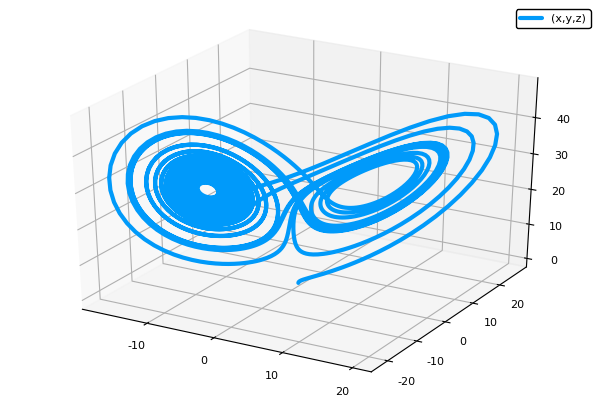

In [9]:
plot(data_sol_short,vars=(1,2,3)) # the short solution
plot(data_sol,vars=(1,2,3)) # the longer solution
interpolation_sol = solve(prob,Vern7(),saveat=t,reltol=1e-12,abstol=1e-12)
plot(interpolation_sol,vars=(1,2,3))

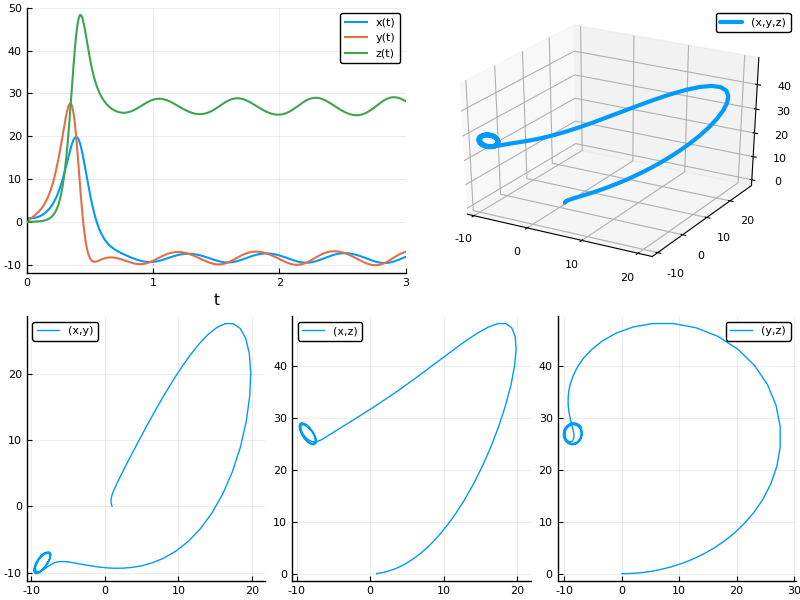

In [10]:
xyzt = plot(data_sol_short, plotdensity=10000,lw=1.5)
xy = plot(data_sol_short, plotdensity=10000, vars=(1,2))
xz = plot(data_sol_short, plotdensity=10000, vars=(1,3))
yz = plot(data_sol_short, plotdensity=10000, vars=(2,3))
xyz = plot(data_sol_short, plotdensity=10000, vars=(1,2,3))
plot(plot(xyzt,xyz),plot(xy, xz, yz, layout=(1,3),w=1), 
    layout=(2,1), size=(800,600))

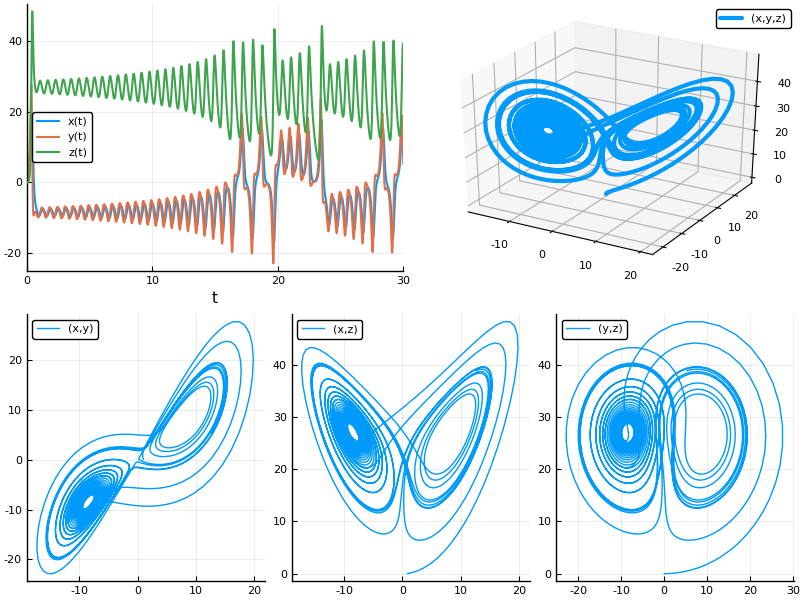

In [11]:
xyzt = plot(data_sol, plotdensity=10000,lw=1.5)
xy = plot(data_sol, plotdensity=10000, vars=(1,2))
xz = plot(data_sol, plotdensity=10000, vars=(1,3))
yz = plot(data_sol, plotdensity=10000, vars=(2,3))
xyz = plot(data_sol, plotdensity=10000, vars=(1,2,3))
plot(plot(xyzt,xyz),plot(xy, xz, yz, layout=(1,3),w=1), layout=(2,1), 
    size=(800,600))

## Find a local solution for the three parameters from a short data set

In [14]:
obj_short = build_loss_objective(
    prob_short,Tsit5(),L2Loss(t_short,data_short),tstops=t_short)
res1 = bboptimize(obj_short;SearchRange = LooserBounds, MaxSteps = 7e3)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 2906 evals, 2804 steps, improv/step: 0.306 (last = 0.3063), fitness=0.025167900
1.00 secs, 5937 evals, 5837 steps, improv/step: 0.298 (last = 0.2905), fitness=0.000000004

Optimization stopped after 7001 steps and 1.19 seconds
Termination reason: Max number of steps (7000) reached
Steps per second = 5858.92
Function evals per second = 5942.61
Improvements/step = 0.29700
Total function evaluations = 7101


Best candidate found: [10.0, 28.0, 2.66]

Fitness: 0.000000000



BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of steps (7000) reached", 7001, 1.581070249812068e9, 1.1949291229248047, DictChain{Symbol,Any}[DictChain{Symbol,Any}[Dict{Symbol,Any}(:RngSeed => 989573,:SearchRange => Tuple{Float64,Float64}[(0.0, 22.0), (0.0, 60.0), (0.0, 6.0)],:MaxSteps => 7000),Dict{Symbol,Any}()],Dict{Symbol,Any}(:FitnessScheme => ScalarFitnessScheme{true}(),:NumDimensions => :NotSpecified,:PopulationSize => 50,:MaxTime => 0.0,:SearchRange => (-1.0, 1.0),:Method => :adaptive_de_rand_1_bin_radiuslimited,:MaxNumStepsWithoutFuncEvals => 100,:RngSeed => 1234,:MaxFuncEvals => 0,:SaveTrace => false…)], 7101, ScalarFitnessScheme{true}(), BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(7.983728835991288e-11, [9.999999522303838, 28.000000015744305, 2.6599999611270984]), BlackBoxOptim.PopulationOptimizerOutput{FitPopulation{Float64}}(FitPopulation{Float64}([9.999999512485411 9.999997790742047 … 9.999997106401308 9.999999066545

In [15]:
obj_short = build_loss_objective(prob_short,Tsit5(),L2Loss(t_short,data_short),tstops=t_short,reltol=1e-9)
res1 = bboptimize(obj_short;SearchRange = LooserBounds, MaxSteps = 7e3)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 2032 evals, 1898 steps, improv/step: 0.283 (last = 0.2829), fitness=6.738485063
1.00 secs, 4063 evals, 3932 steps, improv/step: 0.280 (last = 0.2768), fitness=0.000107313
1.50 secs, 6121 evals, 5993 steps, improv/step: 0.284 (last = 0.2911), fitness=0.000000005

Optimization stopped after 7001 steps and 1.75 seconds
Termination reason: Max number of steps (7000) reached
Steps per second = 3993.50
Function evals per second = 4066.51
Improvements/step = 0.28100
Total function evaluations = 7129


Best candidate found: [10.0, 28.0, 2.66]

Fitness: 0.000000000



BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of steps (7000) reached", 7001, 1.581070282596622e9, 1.7530999183654785, DictChain{Symbol,Any}[DictChain{Symbol,Any}[Dict{Symbol,Any}(:RngSeed => 496634,:SearchRange => Tuple{Float64,Float64}[(0.0, 22.0), (0.0, 60.0), (0.0, 6.0)],:MaxSteps => 7000),Dict{Symbol,Any}()],Dict{Symbol,Any}(:FitnessScheme => ScalarFitnessScheme{true}(),:NumDimensions => :NotSpecified,:PopulationSize => 50,:MaxTime => 0.0,:SearchRange => (-1.0, 1.0),:Method => :adaptive_de_rand_1_bin_radiuslimited,:MaxNumStepsWithoutFuncEvals => 100,:RngSeed => 1234,:MaxFuncEvals => 0,:SaveTrace => false…)], 7129, ScalarFitnessScheme{true}(), BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(3.381836910573271e-11, [9.99999977039411, 28.000000223417775, 2.659999974435692]), BlackBoxOptim.PopulationOptimizerOutput{FitPopulation{Float64}}(FitPopulation{Float64}([10.00000097156632 9.999999119675055 … 9.999999231590298 10.0000009737121

In [16]:
# With the tolerance lower, it achieves the correct solution in 3.5 seconds.
obj_short = build_loss_objective(prob_short,Vern9(),
    L2Loss(t_short,data_short),tstops=t_short,reltol=1e-9,abstol=1e-9)
res1 = bboptimize(obj_short;SearchRange = LooserBounds, MaxSteps = 7e3)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 2101 evals, 1983 steps, improv/step: 0.279 (last = 0.2794), fitness=0.154640166
1.00 secs, 4228 evals, 4112 steps, improv/step: 0.283 (last = 0.2860), fitness=0.000087336
1.50 secs, 6367 evals, 6255 steps, improv/step: 0.287 (last = 0.2944), fitness=0.000000000

Optimization stopped after 7001 steps and 1.67 seconds
Termination reason: Max number of steps (7000) reached
Steps per second = 4193.74
Function evals per second = 4260.83
Improvements/step = 0.28757
Total function evaluations = 7113


Best candidate found: [10.0, 28.0, 2.66]

Fitness: 0.000000000



BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of steps (7000) reached", 7001, 1.581070289010026e9, 1.6693921089172363, DictChain{Symbol,Any}[DictChain{Symbol,Any}[Dict{Symbol,Any}(:RngSeed => 37081,:SearchRange => Tuple{Float64,Float64}[(0.0, 22.0), (0.0, 60.0), (0.0, 6.0)],:MaxSteps => 7000),Dict{Symbol,Any}()],Dict{Symbol,Any}(:FitnessScheme => ScalarFitnessScheme{true}(),:NumDimensions => :NotSpecified,:PopulationSize => 50,:MaxTime => 0.0,:SearchRange => (-1.0, 1.0),:Method => :adaptive_de_rand_1_bin_radiuslimited,:MaxNumStepsWithoutFuncEvals => 100,:RngSeed => 1234,:MaxFuncEvals => 0,:SaveTrace => false…)], 7113, ScalarFitnessScheme{true}(), BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(4.539090815674617e-12, [9.999999936133024, 28.00000004551344, 2.6600000053295667]), BlackBoxOptim.PopulationOptimizerOutput{FitPopulation{Float64}}(FitPopulation{Float64}([9.99999961139062 9.999999936133024 … 9.999999931825172 9.999999482258097

# Using NLopt
First, the global optimization algorithms

In [17]:
obj_short = build_loss_objective(prob_short,Vern9(),
    L2Loss(t_short,data_short),tstops=t_short,reltol=1e-9,abstol=1e-9)


(::DiffEqObjective{DiffEqParamEstim.var"#43#48"{Nothing,Bool,Int64,typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR),Base.Iterators.Pairs{Symbol,Any,Tuple{Symbol,Symbol,Symbol},NamedTuple{(:tstops, :reltol, :abstol),Tuple{Array{Float64,1},Float64,Float64}}},ODEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{Float64,1},LorenzExample{var"#7#11",var"#8#12",var"#9#13",Nothing,Nothing,var"#10#14",Expr,Expr},Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{,Tuple{}}},DiffEqBase.StandardODEProblem},Vern9,L2Loss{Array{Float64,1},Array{Float64,2},Nothing,Nothing,Nothing},Nothing},DiffEqParamEstim.var"#47#53"{DiffEqParamEstim.var"#43#48"{Nothing,Bool,Int64,typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR),Base.Iterators.Pairs{Symbol,Any,Tuple{Symbol,Symbol,Symbol},NamedTuple{(:tstops, :reltol, :abstol),Tuple{Array{Float64,1},Float64,Float64}}},ODEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{Float64,1},LorenzExample{var"#7#11",var"#8#12",var"#9#13",Nothing,Nothing,va

In [18]:
opt = Opt(:GN_ORIG_DIRECT_L, 3)
lower_bounds!(opt,[0.0,0.0,0.0])
upper_bounds!(opt,[22.0,60.0,6.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,GloIniPar) # Accurate 3.2 seconds

  0.919824 seconds (1.57 M allocations: 395.724 MiB, 4.55% gc time)


(7.403132789058194e-18, [10.000000000174282, 28.000000000007077, 2.6600000000125332], :XTOL_REACHED)

In [19]:
opt = Opt(:GN_CRS2_LM, 3)
lower_bounds!(opt,[0.0,0.0,0.0])
upper_bounds!(opt,[22.0,60.0,6.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,GloIniPar) # Accurate 3.0 seconds

  0.821833 seconds (1.36 M allocations: 345.933 MiB, 5.96% gc time)


(2.7757360759092445e-18, [10.000000000053987, 28.000000000022606, 2.660000000008598], :XTOL_REACHED)

In [20]:
opt = Opt(:GN_ISRES, 3)
lower_bounds!(opt,[0.0,0.0,0.0])
upper_bounds!(opt,[22.0,60.0,6.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,GloIniPar) 
# Accurate to single precision 8.2 seconds


  2.301520 seconds (3.98 M allocations: 1013.871 MiB, 3.18% gc time)


(0.0056594871376787, [9.999356824369208, 28.002582161579912, 2.660040143991116], :MAXEVAL_REACHED)

In [21]:
opt = Opt(:GN_ESCH, 3)
lower_bounds!(opt,[0.0,0.0,0.0])
upper_bounds!(opt,[22.0,60.0,6.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,GloIniPar) 
# Approximatively accurate, good starting values for local optimization

  2.280785 seconds (3.98 M allocations: 1013.871 MiB, 3.87% gc time)


(289.39588205368216, [9.282383285597488, 27.97789399302262, 2.544312406858934], :MAXEVAL_REACHED)

Next, the local optimization algorithms that could be used after the global algorithms as a check on the solution and its precision. All the local optimizers are started from LocIniPar and with the narrow bounds of the Xiang2015Paper.

In [22]:
opt = Opt(:LN_BOBYQA, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # 0.1 seconds

  0.055073 seconds (44.99 k allocations: 11.457 MiB)


(2.7676783472649543e-18, [10.000000000052372, 28.000000000022467, 2.660000000008028], :SUCCESS)

In [23]:
opt = Opt(:LN_NELDERMEAD, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Accurate 0.29 sec


  0.098352 seconds (130.16 k allocations: 33.154 MiB)


(2.772090117024207e-18, [10.000000000053243, 28.000000000020528, 2.660000000008175], :XTOL_REACHED)

In [24]:
opt = Opt(:LD_SLSQP, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Accurate 0.21 sec

  0.082291 seconds (174.58 k allocations: 23.322 MiB)


(1.1112322099631885e-15, [9.999999999755278, 28.0000000011971, 2.6600000000042674], :XTOL_REACHED)

In [25]:
opt = Opt(:LN_COBYLA, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Accurate 1.84 sec

  0.486099 seconds (769.59 k allocations: 195.836 MiB, 6.86% gc time)


(2.9382755008911024e-18, [10.000000000027239, 28.000000000027903, 2.6600000000065447], :XTOL_REACHED)

In [26]:
opt = Opt(:LN_NEWUOA_BOUND, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Accurate 0.18 sec ROUNDOFF LIMITED


  0.180465 seconds (101.50 k allocations: 25.854 MiB)


(2.0977630616285726e-8, [10.000007614669004, 28.000000291860562, 2.6600005093015358], :SUCCESS)

In [27]:
opt = Opt(:LN_PRAXIS, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Accurate 0.18 sec

  0.047737 seconds (74.04 k allocations: 18.858 MiB)


(2.7683408773737075e-18, [10.000000000051791, 28.00000000002282, 2.6600000000080595], :XTOL_REACHED)

In [28]:
opt = Opt(:LN_SBPLX, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Accurate 0.65 sec

  0.170191 seconds (297.72 k allocations: 75.838 MiB)


(2.784069880414099e-18, [10.000000000058924, 28.000000000020663, 2.660000000008665], :XTOL_REACHED)

In [29]:
opt = Opt(:LD_MMA, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Accurate 0.7 sec

  0.202487 seconds (326.16 k allocations: 83.671 MiB, 9.90% gc time)


(2.513727923789831e-16, [9.999999999464693, 28.000000000538954, 2.659999999922903], :XTOL_REACHED)

In [30]:
opt = Opt(:LD_LBFGS, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Accurate 0.12 sec


  0.027549 seconds (49.76 k allocations: 12.764 MiB)


(1.1160505492326872e-15, [9.999999999753967, 28.00000000119966, 2.6600000000043185], :SUCCESS)

In [31]:
opt = Opt(:LD_TNEWTON_PRECOND_RESTART, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Accurate 0.15 sec

  0.036804 seconds (63.58 k allocations: 16.309 MiB)


(1.1162287428886917e-15, [9.999999999752498, 28.000000001199844, 2.6600000000043726], :SUCCESS)

# Now let's solve the longer version for a global solution
Notice from the plotting above that this ODE problem is chaotic and tends to diverge over time. In the longer version of parameter estimation, the dataset is increased to 3000 observations per variable with the same integration time step of 0.01. Vern9 solver with reltol=1e-9 and abstol=1e-9 has been established to be accurate on the time interval [0,50]

In [32]:
# BB with Vern9 converges very slowly. The final values are within the NarrowBounds.
obj = build_loss_objective(prob,Vern9(),
    L2Loss(t,data),tstops=t,reltol=1e-9,abstol=1e-9)

res1 = bboptimize(obj;SearchRange = LooserBounds, MaxSteps = 4e3) 
# Default adaptive_de_rand_1_bin_radiuslimited 33 sec 
# [10.2183, 24.6711, 2.28969]

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.51 secs, 206 evals, 138 steps, improv/step: 0.471 (last = 0.4710), fitness=539093.841448912
1.01 secs, 434 evals, 339 steps, improv/step: 0.372 (last = 0.3035), fitness=532262.878754505
1.51 secs, 661 evals, 563 steps, improv/step: 0.330 (last = 0.2679), fitness=528291.923065190
2.01 secs, 886 evals, 789 steps, improv/step: 0.314 (last = 0.2743), fitness=526966.123598570
2.51 secs, 1114 evals, 1017 steps, improv/step: 0.303 (last = 0.2632), fitness=526144.939781936
3.01 secs, 1342 evals, 1245 steps, improv/step: 0.281 (last = 0.1842), fitness=526144.939781936
3.51 secs, 1567 evals, 1470 steps, improv/step: 0.265 (last = 0.1733), fitness=525236.721442663
4.01 secs, 1797 evals, 1701 steps, improv/step: 0.249 (last = 0.1472), fitness=525236.721442663
4.52 secs, 2024 evals, 1928 steps, impr

BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of steps (4000) reached", 4001, 1.581070628351343e9, 9.080394983291626, DictChain{Symbol,Any}[DictChain{Symbol,Any}[Dict{Symbol,Any}(:RngSeed => 965435,:SearchRange => Tuple{Float64,Float64}[(0.0, 22.0), (0.0, 60.0), (0.0, 6.0)],:MaxSteps => 4000),Dict{Symbol,Any}()],Dict{Symbol,Any}(:FitnessScheme => ScalarFitnessScheme{true}(),:NumDimensions => :NotSpecified,:PopulationSize => 50,:MaxTime => 0.0,:SearchRange => (-1.0, 1.0),:Method => :adaptive_de_rand_1_bin_radiuslimited,:MaxNumStepsWithoutFuncEvals => 100,:RngSeed => 1234,:MaxFuncEvals => 0,:SaveTrace => false…)], 4097, ScalarFitnessScheme{true}(), BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(511099.1519172404, [15.52777428237242, 25.09153180272762, 2.361836173059219]), BlackBoxOptim.PopulationOptimizerOutput{FitPopulation{Float64}}(FitPopulation{Float64}([18.990028720212244 19.210290246770793 … 19.03059756174914 18.95939211497221; 

In [33]:
#res1 = bboptimize(obj;SearchRange = LooserBounds, Method = :adaptive_de_rand_1_bin, MaxSteps = 4e3) # Method 32 sec [13.2222, 25.8589, 2.56176]
#res1 = bboptimize(obj;SearchRange = LooserBounds, Method = :dxnes, MaxSteps = 2e3) # Method dxnes 119 sec  [16.8648, 24.393, 2.29119]
#res1 = bboptimize(obj;SearchRange = LooserBounds, Method = :xnes, MaxSteps = 2e3) # Method xnes 304 sec  [19.1647, 24.9479, 2.39467]
#res1 = bboptimize(obj;SearchRange = LooserBounds, Method = :de_rand_1_bin_radiuslimited, MaxSteps = 2e3) # Method 44 sec  [13.805, 24.6054, 2.37274]
#res1 = bboptimize(obj;SearchRange = LooserBounds, Method = :generating_set_search, MaxSteps = 2e3) # Method 195 sec [19.1847, 24.9492, 2.39412]

In [34]:
# using Evolutionary
# N = 3
# @time result, fitness, cnt = cmaes(obj, N; μ = 3, λ = 12, iterations = 1000) # cmaes( rastrigin, N; μ = 15, λ = P, tol = 1e-8)

In [35]:
opt = Opt(:GN_ORIG_DIRECT_L, 3)
lower_bounds!(opt,[0.0,0.0,0.0])
upper_bounds!(opt,[22.0,60.0,6.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,GloIniPar) # Fail to converge

  4.711516 seconds (6.64 M allocations: 1.707 GiB, 2.78% gc time)


(470298.7356885679, [7.04665993025209, 23.666102233396032, 1.8066012972265462], :XTOL_REACHED)

In [36]:
opt = Opt(:GN_CRS2_LM, 3)
lower_bounds!(opt,[0.0,0.0,0.0])
upper_bounds!(opt,[22.0,60.0,6.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 20000)
@time (minf,minx,ret) = NLopt.optimize(opt,GloIniPar) # Hit and miss. converge approximately accurate values for local opt.91 seconds

 43.866076 seconds (62.16 M allocations: 15.977 GiB, 2.44% gc time)


(381177.7570682627, [11.451446202706746, 23.792878418281695, 2.2847387338071767], :MAXEVAL_REACHED)

In [37]:
opt = Opt(:GN_ISRES, 3)
lower_bounds!(opt,[0.0,0.0,0.0])
upper_bounds!(opt,[22.0,60.0,6.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 50000)
@time (minf,minx,ret) = NLopt.optimize(opt,GloIniPar) # Approximately accurate within local bounds


108.825920 seconds (155.40 M allocations: 39.942 GiB, 2.44% gc time)


(479513.88055974967, [8.657491475306674, 24.42436030008991, 2.2639623016026658], :MAXEVAL_REACHED)

In [38]:
opt = Opt(:GN_ESCH, 3)
lower_bounds!(opt,[0.0,0.0,0.0])
upper_bounds!(opt,[22.0,60.0,6.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 20000)
@time (minf,minx,ret) = NLopt.optimize(opt,GloIniPar) # Approximately accurate

 44.409574 seconds (62.16 M allocations: 15.977 GiB, 2.53% gc time)


(536738.2471177777, [1.6523160645378185, 25.535687299721456, 0.7243320937719031], :MAXEVAL_REACHED)

This parameter estimation on the longer sample proves to be extremely challenging for the global optimizers. BlackBoxOptim is best in optimizing the objective function. All of the global algorithms produces final parameter estimates that could be used as starting values for further refinement with the local optimization algorithms.

In [39]:
opt = Opt(:LN_BOBYQA, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Claims SUCCESS but does not iterate to the true values.

  0.263300 seconds (360.54 k allocations: 94.890 MiB, 5.27% gc time)


(588113.2784337488, [9.862590803788724, 20.581133879885893, 2.0], :SUCCESS)

In [40]:
opt = Opt(:LN_NELDERMEAD, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-9)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Inaccurate final values

 22.334795 seconds (31.08 M allocations: 7.988 GiB, 2.57% gc time)


(404754.5095017009, [9.678915633380864, 23.516765371996325, 2.161073807096292], :MAXEVAL_REACHED)

In [41]:
opt = Opt(:LD_SLSQP, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Inaccurate final values

  0.228132 seconds (295.01 k allocations: 77.704 MiB, 5.39% gc time)


(588197.3586264468, [9.936592326777273, 20.554073410669663, 2.0000224406229807], :XTOL_REACHED)

No local optimizer can improve the global solution to the true values.

# Conclusion:
1. As expected the Lorenz system is extremely sensitive to initial space values. Starting the integration from `r0 = [0.1,0.0,0.0]` produces convergence with the short sample of 300 observations. This can be achieved by all the global optimizers as well as most of the local optimizers. Instead starting from `r0= [-11.8,-5.1,37.5]`, as in PODES, with the shorter sample shrinks the number of successful algorithms to 3: `BBO`, `:GN_CRS2_LM` and `:LD_SLSQP`. For the longer sample, all the algorithms fail.

2. When trying to hit the real data, having a low enough tolerance on the numerical solution is key. If the numerical solution is too rough, then we can never actually hone in on the true parameters since even with the true parameters we will erroneously induce numerical error. Maybe this could be adaptive?

3. Excessively low tolerance in the numerical solution is inefficient and delays the convergence of the estimation.

4. The estimation method and the global versus local optimization make a huge difference in the timings. Here, BBO always find the correct solution for a global optimization setup. For local optimization, most methods in NLopt, like `:LN_BOBYQA`, solve the problem in <0.05 seconds. This is an algorithm that can scale a local optimization but we are aiming to scale a global optimization.

5. QuadDIRECT performs very well on the shorter problem but doesn't give very great results for the longer in the Lorenz case, more can be read about the algorithm here.

6. Fitting shorter timespans is easier... maybe this can lead to determining a minimal sample size for the optimizers and the estimator to succeed.

